**Overview**

In [47]:
import random
import tempfile
from pathlib import Path

import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import lightgbm as lgb
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean
import numpy as np
import utilsforecast.processing as ufp
from sklearn.base import BaseEstimator, clone

from utilsforecast.compat import (
    DFType,
    DataFrame,
    pl,
    pl_DataFrame,
    pl_Series,
)

from typing import (
    Any,
    Callable,
    Dict,
    Iterable,
    Iterator,
    List,
    Mapping,
    Optional,
    Tuple,
    Union,
)

In [2]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int64')
df

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
...,...,...,...
4027,H413,1004,99.0
4028,H413,1005,88.0
4029,H413,1006,47.0
4030,H413,1007,41.0


In [3]:
df.groupby(['unique_id']).size()

unique_id
H196    1008
H256    1008
H381    1008
H413    1008
dtype: int64

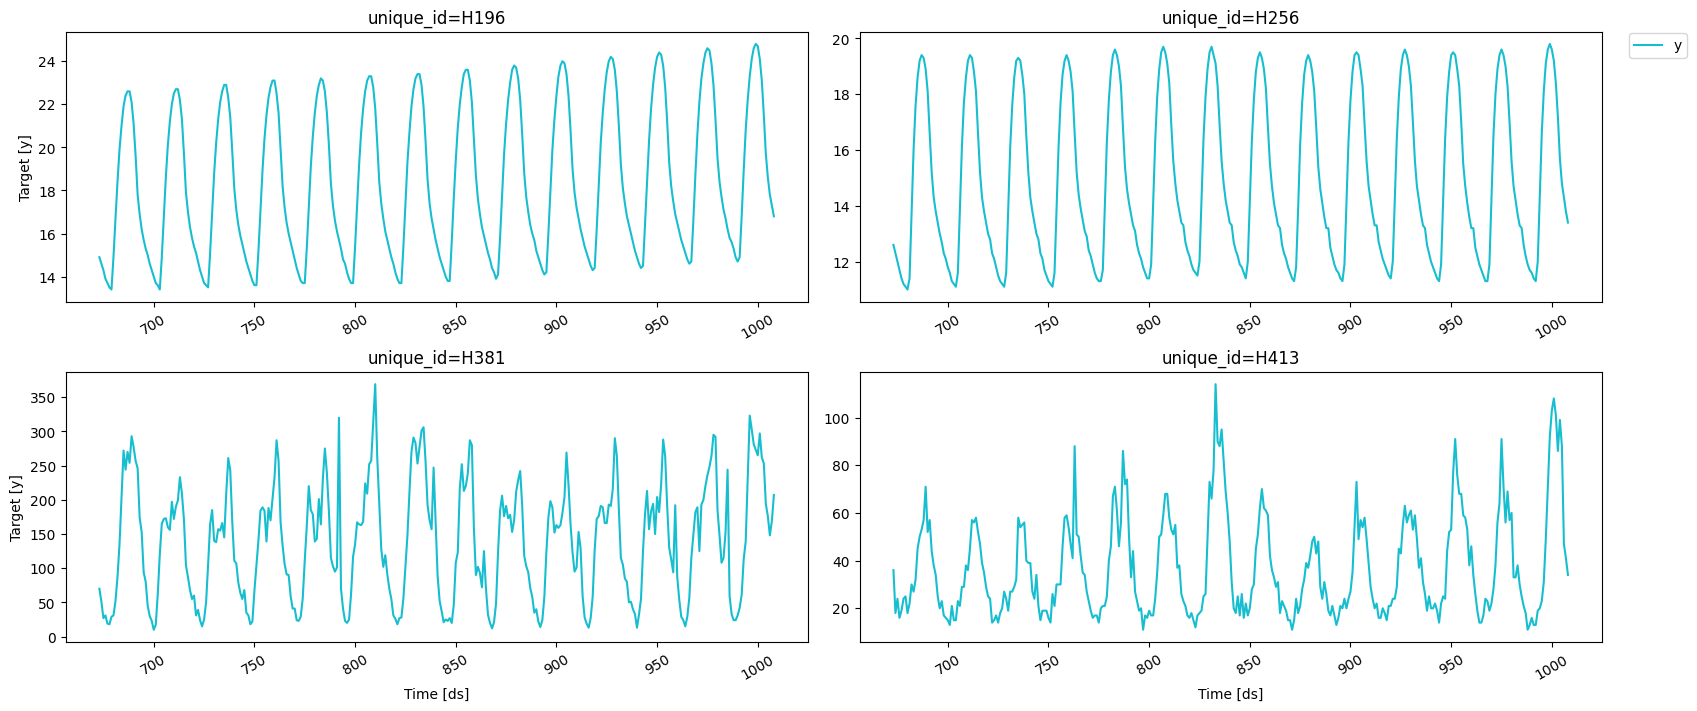

In [4]:
fig = plot_series(df, max_insample_length=24 * 14)
fig

In [5]:
steps = 3

data_train, data_test = [], []

for _, g in df.groupby('unique_id'):
    data_train.append(g.iloc[:-steps, :])
    data_test.append(g.iloc[-steps:, :])

data_train = pd.concat(data_train)
data_test = pd.concat(data_test)    

In [6]:
lgb_params = {
    'verbosity': -1,
    'random_state': 1234
}

fcst = MLForecast(
    models={
        'LGBM': lgb.LGBMRegressor(**lgb_params),
    },
    freq=1,
    lags=[1],
)

In [7]:
fcst.__repr__()

"MLForecast(models=[LGBM], freq=1, lag_features=['lag1'], date_features=[], num_threads=1)"

In [8]:
fcst.fit(data_train, max_horizon=steps, fitted=True)
# preds = fcst.predict(h = horizon)

MLForecast(models=[LGBM], freq=1, lag_features=['lag1'], date_features=[], num_threads=1)

In [10]:
# the following will train a single model and use the recursive strategy

def inspect_input(new_x):
    """Displays the model inputs to inspect them"""
    display(new_x)
    return new_x

preds = fcst.predict(h = steps, before_predict_callback=None)
preds

,unique_id,ds,LGBM
0,H196,1006,18.603706
1,H196,1007,18.607686
2,H196,1008,18.058650
3,H256,1006,14.751819
4,H256,1007,14.907843
5,H256,1008,15.156920
6,H381,1006,181.447969
7,H381,1007,191.205627
8,H381,1008,184.817905
9,H413,1006,88.781230


**Overview .fit method**

Steps:
1. **preprocess()**: crea una tabella con le features della y e le due trasformazioni, le variabili esogene con le loro trasformazioni.    
2. **fit()**: Vengono eliminate le righe nel train con y NaN; ogni modello viene fittato con lo stesso dataset che contiene le features di tutte le serie storiche (nel nostro use case forse andrebbe emesso qualcosa per differenziarle) e vengono date in pasto ad un modello che prevede una target differente, ovvero una y a t+1,..,t+3. Quindi il modello rimane globale ed è anche un modello che tiene in considerazione l'ordine temporale per come sono costruite le finestre. Alla fine, ho steps nuovi modelli fittati.  
3. **predict()**: per ogni ori

In [17]:
fcst = MLForecast(
    models={
        'LGBM': lgb.LGBMRegressor(**lgb_params),
    },
    freq=1,
    lags=[1],
)

In [18]:
data_train.head()

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6


In [36]:
# Step 1: costruire il dataset
# In questo caso, il lag1 è l'unica variabile che verrà considerata
# per prevedere y0, y1 e y2. 

prep = fcst.preprocess(df = data_train,
                       id_col = 'unique_id',
                       time_col = 'ds', 
                       target_col = 'y',
                       static_features = None,
                       dropna = True, 
                       max_horizon = steps,                       
                       return_X_y=True
                       )
X, y = prep

In [37]:
prep

,unique_id,ds,lag1,y0,y1,y2
1,H196,2,11.8,11.4,11.1,10.8
2,H196,3,11.4,11.1,10.8,10.6
3,H196,4,11.1,10.8,10.6,10.3
4,H196,5,10.8,10.6,10.3,10.1
5,H196,6,10.6,10.3,10.1,10.6
...,...,...,...,...,...,...
4024,H413,1001,103.0,108.0,101.0,86.0
4025,H413,1002,108.0,101.0,86.0,99.0
4026,H413,1003,101.0,86.0,99.0,88.0
4027,H413,1004,86.0,99.0,88.0,NaN


In [25]:
X

,lag1
1,11.8
2,11.4
3,11.1
4,10.8
5,10.6
...,...
4024,103.0
4025,108.0
4026,101.0
4027,86.0


In [27]:
pd.DataFrame(y)

,0,1,2
0,11.4,11.1,10.8
1,11.1,10.8,10.6
2,10.8,10.6,10.3
3,10.6,10.3,10.1
4,10.3,10.1,10.6
...,...,...,...
4011,108.0,101.0,86.0
4012,101.0,86.0,99.0
4013,86.0,99.0,88.0
4014,99.0,88.0,NaN


In [22]:
# Step 2: Training 

fcst.models_ = {}

for name, model in fcst.models.items():
    if y.ndim == 2 and y.shape[1] > 1:
        fcst.models_[name] = []
        # ciclo sui vari step, quindi sui modelli da fittare
        for col in range(y.shape[1]):
            keep = ~np.isnan(y[:, col])
            if isinstance(X, np.ndarray):
                print('an array')
                Xh = X[keep]
            else:
                Xh = ufp.filter_with_mask(X, keep)
            yh = y[keep, col]
            fcst.models_[name].append(model.fit(Xh, yh))
    else:
        fcst.models_[name] = clone(model).fit(X, y)

In [29]:
fcst.models_

{'LGBM': [LGBMRegressor(random_state=1234, verbosity=-1),
  LGBMRegressor(random_state=1234, verbosity=-1),
  LGBMRegressor(random_state=1234, verbosity=-1)]}

In [40]:
Xh

,lag1
1,11.8
2,11.4
3,11.1
4,10.8
5,10.6
...,...
4022,70.0
4023,92.0
4024,103.0
4025,108.0


In [41]:
y[:, 2]

array([10.8, 10.6, 10.3, ..., 88. ,  nan,  nan])

In [42]:
yh

array([10.8, 10.6, 10.3, ..., 86. , 99. , 88. ])

In [43]:
# Step 3: predict

h = steps
before_predict_callback = None 
after_predict_callback = None 
new_df = None
level = None
X_df = None
ids = None


if not hasattr(fcst, "models_"):
    raise ValueError(
        "No fitted models found. You have to call fit or preprocess + fit_models. "
        "If you used cross_validation before please fit again."
    )
first_model_is_list = isinstance(next(iter(fcst.models_.values())), list)
max_horizon = fcst.ts.max_horizon
if first_model_is_list and max_horizon is None:
    raise ValueError(
        "Found one model per horizon but `max_horizon` is None. "
        "If you ran preprocess after fit please run fit again."
    )
elif not first_model_is_list and max_horizon is not None:
    raise ValueError(
        "Found a single model for all horizons "
        f"but `max_horizon` is {max_horizon}. "
        "If you ran preprocess after fit please run fit again."
    )

if new_df is not None:
    if level is not None:
        raise ValueError(
            "Prediction intervals are not supported in transfer learning."
        )
    new_ts = TimeSeries(
        freq=self.ts.freq,
        lags=self.ts.lags,
        lag_transforms=self.ts.lag_transforms,
        date_features=self.ts.date_features,
        num_threads=self.ts.num_threads,
        target_transforms=self.ts.target_transforms,
        lag_transforms_namer=self.ts.lag_transforms_namer,
    )
    new_ts._fit(
        new_df,
        id_col=self.ts.id_col,
        time_col=self.ts.time_col,
        target_col=self.ts.target_col,
        static_features=self.ts.static_features,
        keep_last_n=self.ts.keep_last_n,
    )
    core_tfms = new_ts._get_core_lag_tfms()
    if core_tfms:
        # populate the stats needed for the updates
        new_ts._compute_transforms(core_tfms, updates_only=False)
    new_ts.max_horizon = self.ts.max_horizon
    new_ts.as_numpy = self.ts.as_numpy
    ts = new_ts
else:
    print('Sono qui')
    ts = fcst.ts

forecasts = ts.predict(
    models=fcst.models_,
    horizon=h,
    before_predict_callback=before_predict_callback,
    after_predict_callback=after_predict_callback,
    X_df=X_df,
    ids=ids,
)
# if level is not None:
#     if self._cs_df is None:
#         warn_msg = (
#             "Please rerun the `fit` method passing a proper value "
#             "to prediction intervals to compute them."
#         )
#         warnings.warn(warn_msg, UserWarning)
#     else:
#         if (self.prediction_intervals.h != 1) and (
#             self.prediction_intervals.h < h
#         ):
#             raise ValueError(
#                 "The `h` argument of PredictionIntervals "
#                 "should be equal to one or greater or equal to `h`. "
#                 "Please rerun the `fit` method passing a proper value "
#                 "to prediction intervals."
#             )
#         if self.prediction_intervals.h == 1 and h > 1:
#             warn_msg = (
#                 "Prediction intervals are calculated using 1-step ahead cross-validation, "
#                 "with a constant width for all horizons. To vary the error by horizon, "
#                 "pass PredictionIntervals(h=h) to the `prediction_intervals` "
#                 "argument when refitting the model."
#             )
#             warnings.warn(warn_msg, UserWarning)
#         level_ = sorted(level)
#         model_names = self.models.keys()
#         conformal_method = _get_conformal_method(
#             self.prediction_intervals.method
#         )
#         if ids is not None:
#             ids_mask = ufp.is_in(self._cs_df[self.ts.id_col], ids)
#             cs_df = ufp.filter_with_mask(self._cs_df, ids_mask)
#             n_series = len(ids)
#         else:
#             cs_df = self._cs_df
#             n_series = self.ts.ga.n_groups
#         forecasts = conformal_method(
#             forecasts,
#             cs_df,
#             model_names=list(model_names),
#             level=level_,
#             cs_h=self.prediction_intervals.h,
#             cs_n_windows=self.prediction_intervals.n_windows,
#             n_series=n_series,
#             horizon=h,
#         )

Sono qui


In [44]:
forecasts

,unique_id,ds,LGBM
0,H196,1006,18.058650
1,H196,1007,18.058650
2,H196,1008,18.058650
3,H256,1006,15.156920
4,H256,1007,15.156920
5,H256,1008,15.156920
6,H381,1006,184.817905
7,H381,1007,184.817905
8,H381,1008,184.817905
9,H413,1006,99.830352


In [46]:
models=fcst.models_
horizon=h
before_predict_callback=None
after_predict_callback=None
X_df=None
ids=None

# def predict(
        # self,
        # models: Dict[str, Union[BaseEstimator, List[BaseEstimator]]],
        # horizon: int,
        # before_predict_callback: Optional[Callable] = None,
        # after_predict_callback: Optional[Callable] = None,
        # X_df: Optional[DFType] = None,
        # ids: Optional[List[str]] = None,
    # ) -> DFType:

if ids is not None:
    unseen = set(ids) - set(self.uids)
    if unseen:
        raise ValueError(
            f"The following ids weren't seen during training and thus can't be forecasted: {unseen}"
        )
    idxs: Optional[np.ndarray] = np.where(ufp.is_in(self.uids, ids))[0]
else:
    idxs = None
    
with ts._maybe_subset(idxs):
    if X_df is not None:
        if self.id_col not in X_df or self.time_col not in X_df:
            raise ValueError(
                f"X_df must have '{self.id_col}' and '{self.time_col}' columns."
            )
        if X_df.shape[1] < 3:
            raise ValueError("Found no exogenous features in `X_df`.")
        statics = [c for c in self.static_features_.columns if c != self.id_col]
        dynamics = [
            c for c in X_df.columns if c not in [self.id_col, self.time_col]
        ]
        common = [c for c in dynamics if c in statics]
        if common:
            raise ValueError(
                f"The following features were provided through `X_df` but were considered as static during fit: {common}.\n"
                "Please re-run the fit step using the `static_features` argument to indicate which features are static. "
                "If all your features are dynamic please pass an empty list (static_features=[])."
            )
        starts = ufp.offset_times(self.last_dates, self.freq, 1)
        ends = ufp.offset_times(self.last_dates, self.freq, horizon)
        dates_validation = type(X_df)(
            {
                self.id_col: self.uids,
                "_start": starts,
                "_end": ends,
            }
        )
        X_df = ufp.join(X_df, dates_validation, on=self.id_col)
        mask = ufp.between(X_df[self.time_col], X_df["_start"], X_df["_end"])
        X_df = ufp.filter_with_mask(X_df, mask)
        if X_df.shape[0] != len(self.uids) * horizon:
            msg = (
                "Found missing inputs in X_df. "
                "It should have one row per id and time for the complete forecasting horizon.\n"
                "You can get the expected structure by running `MLForecast.make_future_dataframe(h)` "
                "or get the missing combinatins in your current `X_df` by running `MLForecast.get_missing_future(h, X_df)`."
            )
            raise ValueError(msg)
        drop_cols = [self.id_col, self.time_col, "_start", "_end"]
        X_df = ufp.sort(X_df, [self.id_col, self.time_col])
        X_df = ufp.drop_columns(X_df, drop_cols)
    if getattr(ts, "max_horizon", None) is None:
        print("Recursive forecasting")
        preds = self._predict_recursive(
            models=models,
            horizon=horizon,
            before_predict_callback=before_predict_callback,
            after_predict_callback=after_predict_callback,
            X_df=X_df,
        )
    else:
        print("Direct forecasting")
        preds = ts._predict_multi(
            models=models,
            horizon=horizon,
            before_predict_callback=before_predict_callback,
            X_df=X_df,
        )
    if ts.target_transforms is not None:
        if self._has_ga_target_tfms():
            model_cols = [
                c
                for c in preds.columns
                if c not in (self.id_col, self.time_col)
            ]
            indptr = np.arange(0, horizon * (len(self.uids) + 1), horizon)
        for tfm in self.target_transforms[::-1]:
            if isinstance(tfm, _BaseGroupedArrayTargetTransform):
                for col in model_cols:
                    ga = GroupedArray(
                        preds[col].to_numpy().astype(self.ga.data.dtype), indptr
                    )
                    ga = tfm.inverse_transform(ga)
                    preds = ufp.assign_columns(preds, col, ga.data)
            else:
                preds = tfm.inverse_transform(preds)
# return preds

Direct forecasting


In [53]:
models=fcst.models_
horizon=3
before_predict_callback=None
X_df=None

# def _predict_multi(
#     self,
#     models: Dict[str, BaseEstimator],
#     horizon: int,
#     before_predict_callback: Optional[Callable] = None,
#     X_df: Optional[DFType] = None,
# ) -> DFType:

# assert self.max_horizon is not None
# if horizon > self.max_horizon:
#     raise ValueError(
#         f"horizon must be at most max_horizon ({self.max_horizon})"
#     )
# self._predict_setup()
if isinstance(ts.last_dates, pl_Series):
    ts.curr_dates = ts.last_dates.clone()
else:
    ts.curr_dates = ts.last_dates.copy()
ts.test_dates: List[Union[pd.Index, pl_Series]] = []
ts.y_pred = []
ts._h = 0

# uids = self._get_future_ids(horizon)
if isinstance(ts.uids, pl_Series):
    uids = pl.concat([ts.uids for _ in range(h)]).sort()
else:
    uids = pd.Series(
        np.repeat(ts.uids, h), name=ts.id_col, dtype=ts.uids.dtype
    )

starts = ufp.offset_times(ts.curr_dates, ts.freq, 1)
dates = ufp.time_ranges(starts, ts.freq, periods=horizon)
if isinstance(ts.curr_dates, pl_Series):
    df_constructor = pl_DataFrame
else:
    df_constructor = pd.DataFrame
result = df_constructor({ts.id_col: uids, ts.time_col: dates})

for name, model in models.items():
    print(name, model)
    # with ts._backup():
    new_x = ts._get_features_for_next_step(X_df)
    print(new_x)
    if before_predict_callback is not None:
        new_x = before_predict_callback(new_x)
    predictions = np.empty((new_x.shape[0], horizon))
    for i in range(horizon):
        predictions[:, i] = model[i].predict(new_x)
    raw_preds = predictions.ravel()
    result = ufp.assign_columns(result, name, raw_preds)

result

LGBM [LGBMRegressor(random_state=1234, verbosity=-1), LGBMRegressor(random_state=1234, verbosity=-1), LGBMRegressor(random_state=1234, verbosity=-1)]
    lag1
0   18.6
1   14.8
2  176.0
3   88.0


,unique_id,ds,LGBM
0,H196,1006,18.058650
1,H196,1007,18.058650
2,H196,1008,18.058650
3,H256,1006,15.156920
4,H256,1007,15.156920
5,H256,1008,15.156920
6,H381,1006,184.817905
7,H381,1007,184.817905
8,H381,1008,184.817905
9,H413,1006,99.830352


In [54]:
#   def _get_features_for_next_step(self, X_df=None):
new_x = ts._update_features()
new_x
# if X_df is not None:
#     n_series = len(self.uids)
#     h = X_df.shape[0] // n_series
#     rows = np.arange(self._h, X_df.shape[0], h)
#     X = ufp.take_rows(X_df, rows)
#     X = ufp.drop_index_if_pandas(X)
#     new_x = ufp.horizontal_concat([new_x, X])
# if isinstance(new_x, pd.DataFrame):
#     nulls = new_x.isnull().any()
#     cols_with_nulls = nulls[nulls].index.tolist()
# else:
#     nulls = new_x.select(pl.all().is_null().any())
#     cols_with_nulls = [k for k, v in nulls.to_dicts()[0].items() if v]
# if cols_with_nulls:
#     warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
# self._h += 1
# new_x = new_x[self.features_order_]
# if self.as_numpy:
#     new_x = ufp.to_numpy(new_x)
# return new_x

,unique_id,lag1
0,H196,18.6
1,H256,14.8
2,H381,176.0
3,H413,88.0


In [52]:
result

,unique_id,ds,LGBM
0,H196,1006,18.058650
1,H196,1007,18.058650
2,H196,1008,18.058650
3,H256,1006,15.156920
4,H256,1007,15.156920
5,H256,1008,15.156920
6,H381,1006,184.817905
7,H381,1007,184.817905
8,H381,1008,184.817905
9,H413,1006,99.830352


In [ ]:
# dati retail
# recursuve, direct, old stesse condizioni iniziali
# dati combo